In [ ]:
!pip install numpy catboost

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


+--------------+------------------------------------------------+-------------+------------+------------+-----------+
| Model        | Best Params                                    |   Train MSE |   Test MSE |   Train R2 |   Test R2 |
+==============+================================================+=============+============+============+===========+
| SVR          | {'kernel': 'rbf', 'C': 10}                     |     1.24188 |    2.88901 |   0.732139 |  0.329021 |
+--------------+------------------------------------------------+-------------+------------+------------+-----------+
| DecisionTree | {'min_samples_split': 2, 'max_depth': 3}       |     3.50892 |    3.66707 |   0.243161 |  0.148314 |
+--------------+------------------------------------------------+-------------+------------+------------+-----------+
| RandomForest | {'n_estimators': 200, 'max_depth': 7}          |     1.53838 |    2.74811 |   0.668188 |  0.361744 |
+--------------+----------------------------------------

<ipython-input-3-0d1738cf886a>:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models, rotation=45)


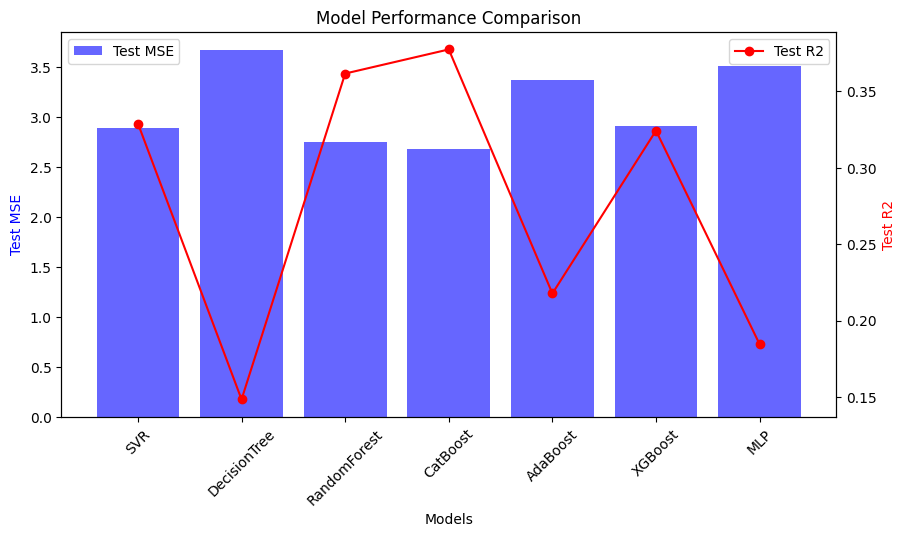

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/GST - C_AST.csv')

# Feature-target split
X = df.drop('Final_Marks', axis=1)
y = df['Final_Marks']

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models and parameter grids
models = {
    'SVR': (SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}),
    'DecisionTree': (DecisionTreeRegressor(), {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}),
    'RandomForest': (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}),
    'CatBoost': (CatBoostRegressor(verbose=0), {'depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}),
    'AdaBoost': (AdaBoostRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}),
    'XGBoost': (XGBRegressor(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'MLP': (MLPRegressor(max_iter=1000), {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]})
}

results = []
performance = {}

# Hyperparameter tuning and evaluation
for name, (model, params) in models.items():
    random_search = RandomizedSearchCV(model, params, n_iter=5, cv=3, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    results.append([name, random_search.best_params_, train_mse, test_mse, train_r2, test_r2])
    performance[name] = {'Test MSE': test_mse, 'Test R2': test_r2}

# Display results
print(tabulate(results, headers=["Model", "Best Params", "Train MSE", "Test MSE", "Train R2", "Test R2"], tablefmt="grid"))

# Plot performance
def plot_performance(performance):
    models = list(performance.keys())
    test_mse = [performance[m]['Test MSE'] for m in models]
    test_r2 = [performance[m]['Test R2'] for m in models]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    ax1.bar(models, test_mse, color='b', alpha=0.6, label='Test MSE')
    ax2.plot(models, test_r2, color='r', marker='o', label='Test R2')

    ax1.set_xlabel('Models')
    ax1.set_ylabel('Test MSE', color='b')
    ax2.set_ylabel('Test R2', color='r')
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('Model Performance Comparison')
    plt.show()

plot_performance(performance)